In [1]:
import scipy.ndimage as sim
from PIL import Image, ImageDraw, ImageFont
import numpy as np
import SimpleITK as sitk
import matplotlib.pyplot as plt

In [2]:
def count_distance_to_centre(region, centre_of_lumen, dists, only_angle = True):
    
    if only_angle == False:

        for n in range(region.shape[0]):
                dists[n, 0] = np.sqrt((region[n, 0]-centre_of_lumen[0])**2+(region[n, 1]-centre_of_lumen[1])**2)
                dists[n, 1] = np.degrees(np.arctan2((region[n, 0]-centre_of_lumen[0]), (region[n, 1]-centre_of_lumen[1])))

    else:
        for n in range(region.shape[0]):
                dists[n, 0] = np.degrees(np.arctan2((region[n, 0]-centre_of_lumen[0]), (region[n, 1]-centre_of_lumen[1])))

    return dists
    

In [11]:
def create_annotations(image, conv_fact = 1, im_insize = 704, bin_size = 2):    
    # Define segmentations
    vessel_bg = image == 0
    vessel_center = image == 1
    vessel_guide = image == 2
    vessel_lipid = image == 4
    vessel_wall = image == 3
    vessel_calcium = image == 5
    
    # Pixel IDs segmentations
    bg_pixels = np.argwhere(vessel_bg)
    wall_pixels = np.argwhere(vessel_wall)
    lipid_pixels = np.argwhere(vessel_lipid)
    guide_pixels = np.argwhere(vessel_guide)
    calcium_pixels = np.argwhere(vessel_calcium)


    if lipid_pixels.size==0 and calcium_pixels.size==0:

        return np.zeros((im_insize, im_insize), np.uint8), np.zeros(360//bin_size), 0, 0

    else:
    
        # Center of mass of vessel center
        vessel_com = sim.center_of_mass(vessel_center)

        # Determine distance and angle of pixels relative to COM
        dist_bg = np.zeros((bg_pixels.shape[0], 1))
        dist_wall = np.zeros((wall_pixels.shape[0], 2))
        dist_lipid = np.zeros((lipid_pixels.shape[0], 1))
        dist_guide = np.zeros((guide_pixels.shape[0], 1))
        dist_calcium = np.zeros((calcium_pixels.shape[0], 2))


        dist_wall = count_distance_to_centre(wall_pixels, vessel_com, dist_wall, only_angle=False)
        dist_lipid = count_distance_to_centre(lipid_pixels, vessel_com, dist_lipid)
        dist_guide = count_distance_to_centre(guide_pixels, vessel_com, dist_guide)
        dist_calcium = count_distance_to_centre(calcium_pixels, vessel_com, dist_calcium, only_angle=False)

            
        # Bin pixels in 360 degree bins
        hist_count_wall, bins_wall = np.histogram(dist_wall[:, 1], 360//bin_size, (-180, 180))
        hist_count_lipid, bins = np.histogram(dist_lipid[:, 0], 360//bin_size, (-180, 180))
        hist_count_guide, bins_tube = np.histogram(dist_guide[:, 0], 360//bin_size, (-180, 180))
        hist_count_calcium, bins_cal = np.histogram(dist_calcium[:, 1], 360//bin_size, (-180, 180))
        #hist_count_wall_tube = hist_count_wall+hist_count_tube

        fat_ids = np.where(hist_count_lipid > 0)[0]

        if fat_ids.size == 0:
            return np.zeros((im_insize, im_insize), np.uint8), np.zeros(360 // bin_size), 0, 0

        # Get contours of wall
        new_image = np.copy(image).astype('int16')
        new_image[new_image == 2] = 10
        new_image[new_image == 4] = 0
        new_image[new_image == 5] = 3
        new_image[new_image == 6] = 0
        new_image[new_image == 7] = 1
        new_image[new_image == 8] = 10
        new_image[new_image == 9] = 10
        new_image[new_image == 10] = 10
        new_image[new_image == 11] = 10
        new_image[new_image == 12] = 10

        edges1 = np.abs(np.diff(new_image, axis=0))
        edges2 = np.abs(np.diff(new_image, axis=1))

        contours = np.zeros((704, 704))
        contours2 = np.zeros((704, 704))

        contours[:703, :704] = edges1 == 3
        contours2[:704, :703] = edges2 == 3

        contours[contours == 0] = contours2[contours == 0]

        contours3 = np.zeros((704, 704))
        contours4 = np.zeros((704, 704))

        contours3[:703, :704] = edges1 == 2
        contours4[:704, :703] = edges2 == 2
        contours3[contours3 == 0] = contours4[contours3 == 0]

        id1 = np.argwhere(contours == 1)
        id2 = np.argwhere(contours3 == 1)


        # Determine angle fat
        wcontour_pixels = np.argwhere(contours)
        dist_wcontour = np.zeros((wcontour_pixels.shape[0], 1))

        for n in range(wcontour_pixels.shape[0]):
            dist_wcontour[n, 0] = np.degrees(
                np.arctan2((wcontour_pixels[n, 0] - vessel_com[0]), (wcontour_pixels[n, 1] - vessel_com[1])))
        hist_count_wcontour, bins_wcontour = np.histogram(dist_wcontour[:, 0], 360//bin_size, (-180, 180))

        tube_ids = np.where(hist_count_tube > 0)[0]
        wall_nids = np.where(hist_count_wcontour == 0)[0]


        # Add tube ids if fat overlaps tube at both sides
        overlap_fat_tube = np.isin(fat_ids,np.concatenate((wall_nids-3,wall_nids+3)))
        #print(fat_ids)
        #print(np.concatenate((wall_nids-3,wall_nids+3)))
        if np.sum(overlap_fat_tube)>1:
            #print(wall_nids)
            overlap_fat_ids = fat_ids[overlap_fat_tube]
            #print(overlap_fat_ids)
            overlap_fat_tube_diff = np.diff(overlap_fat_ids)
            max_diff_id = np.argmax(overlap_fat_tube_diff)
            if overlap_fat_tube_diff[max_diff_id] > 1:
#                 if np.isin(0,tube_ids) and np.isin(179,tube_ids):
#                     print(max_diff_id)
#                     if overlap_fat_tube_diff[max_diff_id]>90:
#                         added_ids = np.concatenate((np.arange(0, overlap_fat_ids[max_diff_id]+1),np.arange(overlap_fat_ids[max_diff_id+1],180)))
#                     else: 
#                         added_ids = np.arange(overlap_fat_ids[max_diff_id],overlap_fat_ids[max_diff_id+1])
#                     print(overlap_fat_ids)
#                     print(added_ids)
#                 else:
#                     added_ids = np.arange(overlap_fat_ids[max_diff_id],overlap_fat_ids[max_diff_id+1])
                added_ids = np.unique(np.concatenate((wall_nids-3,wall_nids,wall_nids+3)))
                added_ids = added_ids[(added_ids>-1) & (added_ids<180)]
                #print(added_ids)
                fat_ids = np.unique(np.concatenate((fat_ids,added_ids)))
                
        fat_angle_deg = len(fat_ids)/(len(bins)-1)*360

        # Detect edges of fat
        fat_bool = np.zeros(len(bins)-1)
        fat_bool[fat_ids]=1

        if np.sum(fat_bool < 1)==0 or np.sum(fat_bool < 1)==fat_bool.shape[0]:
            fat_edges = np.array([])
        else:
            fat_edges = np.where(np.abs(np.diff(fat_bool)) > 0)[0]

            if np.abs(fat_bool[0]-fat_bool[-1])>0:
                fat_edges = np.concatenate((fat_edges,np.array([-1])))
                                      
            if fat_bool[fat_edges[0]] > 0:
                fat_edges = np.roll(fat_edges,1)
                
            fat_edges = fat_edges+1
            


        fat_edge1 = np.zeros((fat_edges.size//2,2))
        fat_edge2 = np.zeros((fat_edges.size//2,2))
        fat_angles = np.zeros((fat_edges.size//2,2))

        # Calculate fat edge coordinates
        for n in range(fat_edges.size//2):
            #fat_angle_ids = fat_ids[[fat_edges[n],fat_edges[n]+1]]
            fat_angle_ids = [fat_edges[2*n],fat_edges[2*n+1]]
            fat_angles[n] = bins[fat_angle_ids]+bin_size/2

            fat_edge1[n,0] = vessel_com[1]+(image.shape[0]*0.4*np.cos(np.radians(fat_angles[n,0])))
            fat_edge1[n,1] = vessel_com[0]+(image.shape[0]*0.4*np.sin(np.radians(fat_angles[n,0])))

            fat_edge2[n,0] = vessel_com[1]+(image.shape[0]*0.4*np.cos(np.radians(fat_angles[n,1])))
            fat_edge2[n,1] = vessel_com[0]+(image.shape[0]*0.4*np.sin(np.radians(fat_angles[n,1])))
        
        if cal_pixels.size>0:
            cal_ids = np.where(hist_count_cal > 0)[0]
            #fat_ids = np.unique(np.concatenate((fat_ids,cal_ids),0))

        fat_bins = bins[fat_ids]
#        angle_id = np.argmin(hist_count_wall_tube[fat_ids])
#        angle = fat_bins[angle_id]
               

#         thin_id = (np.digitize(dist_wall[:, 1], bins)-1) == fat_ids[angle_id]

#         if dist_wall[thin_id, 0].size == 0:
#             #thin_id = np.digitize(dist_fat[:, 1], bins) == fat_ids[angle_id]
#             min_dist = 0
#             max_dist = 0
#         else:
#             min_dist = np.min(dist_wall[thin_id, 0])
#             if cal_pixels.size>0:
#                 thin_id_cal = (np.digitize(dist_cal[:, 1], bins)-1) == fat_ids[angle_id]
#                 if dist_cal[thin_id_cal, 0].size == 0:
#                     max_dist = np.max(dist_wall[thin_id, 0])
#                 else:
#                     max_dist = np.min(dist_cal[thin_id_cal, 0])
#             else:
#                 max_dist = np.max(dist_wall[thin_id, 0])
                
#         thickness = max_dist - min_dist


        # Calculate coordinates thinnest point

        angle_edge1 = np.zeros((id1.shape[0], 1))
        angle_edge2 = np.zeros((id2.shape[0], 1))

        for n in range(id1.shape[0]):
            angle_edge1[n, 0] = np.degrees(np.arctan2((id1[n, 0]-vessel_com[0]), (id1[n, 1]-vessel_com[1])))
        for n in range(id2.shape[0]):
            angle_edge2[n, 0] = np.degrees(np.arctan2((id2[n, 0]-vessel_com[0]), (id2[n, 1]-vessel_com[1])))
        
        angle_bin1 = np.digitize(angle_edge1[:, 0], bins)
        angle_bin2 = np.digitize(angle_edge2[:, 0], bins)
        thin_id1 = np.isin(bins[angle_bin1-1],fat_bins)
        thin_id2 = np.isin(bins[angle_bin2-1],fat_bins)

        id1_fat = id1[thin_id1]
        id2_fat = id2[thin_id2]
        #print(id1_fat)
        #print(id2_fat)
        if id1_fat.size==0 or id2_fat.size==0:
#             overlay = np.zeros((image.shape[0],image.shape[1]), np.uint8) 
#             pil_image = Image.fromarray(overlay)
#             contour_image = Image.fromarray(contours.astype('uint8')*11).convert('L')
#             pil_image.paste(contour_image)
            return np.zeros((im_insize,im_insize), np.uint8), np.zeros(360//bin_size) 


        id1_min = np.zeros(id1_fat.shape[0])
        id1_argmin = np.zeros(id1_fat.shape[0]).astype('int16')
        for n in range(id1_fat.shape[0]):
            C = []
            for nn in range(id2_fat.shape[0]):

                C.append((id1_fat[n,0]-id2_fat[nn,0])**2+(id1_fat[n,1]-id2_fat[nn,1])**2)
            id1_argmin[n] = np.argmin(C)
            id1_min[n] = C[id1_argmin[n]]
        
        contours3[contours3==0]=contours[contours3==0]

        id1m = np.argmin(id1_min)
        id2m = id1_argmin[id1m]
                           
        #id1m,id2m = np.divmod(id_min,id2_fat.shape[0])
        id1_min = np.sqrt(id1_min)*1000/conv_fact
        thickness = id1_min[id1m]/100
        
        thin_x = id1_fat[id1m,1]
        thin_y = id1_fat[id1m,0]
        thin_x2 = id2_fat[id2m,1]
        thin_y2 = id2_fat[id2m,0]
        
        # thickness per lipid/calcium bin
        thickness_bin = np.zeros(bins.shape[0]-1)                
        for n in range(thickness_bin.shape[0]-1):
            try:
                thickness_bin[n] = np.min(id1_min[angle_bin1[thin_id1]==(n+1)])
            except (ValueError, TypeError):
                if hist_count_tube[n]>0:
                    thickness_bin[n] = -1
                
        # Pil manipulations
        overlay = np.zeros((image.shape[0],image.shape[1]), np.uint8) 
        pil_image = Image.fromarray(overlay)

        contour_image = Image.fromarray(contours.astype('uint8')*16).convert('L')
        pil_image.paste(contour_image)
        
        img1 = ImageDraw.Draw(pil_image)   
        img1.line([(thin_x,thin_y),(thin_x2,thin_y2)], fill = 13, width = 3)
        dotsize=3
        img1.ellipse([(thin_x-dotsize,thin_y-dotsize),(thin_x+dotsize,thin_y+dotsize)], fill = 13, width = 0) 
        img1.ellipse([(thin_x2-dotsize,thin_y2-dotsize),(thin_x2+dotsize,thin_y2+dotsize)], fill = 13, width = 0)
        
        
        for n in range(fat_edges.shape[0]//2):
            img1.line([(vessel_com[1], vessel_com[0]), (fat_edge1[n,0], fat_edge1[n,1])],fill = 14, width = 3)
            img1.line([(vessel_com[1], vessel_com[0]), (fat_edge2[n,0], fat_edge2[n,1])],fill = 14, width = 3)

            dotsize=3
            img1.ellipse([(fat_edge1[n,0]-dotsize,fat_edge1[n,1]-dotsize),(fat_edge1[n,0]+dotsize,fat_edge1[n,1]+dotsize)], fill = 14, width = 0) 
            img1.ellipse([(fat_edge2[n,0]-dotsize,fat_edge2[n,1]-dotsize),(fat_edge2[n,0]+dotsize,fat_edge2[n,1]+dotsize)], fill = 14, width = 0) 
            img1.arc([(vessel_com[1]-30,vessel_com[0]-30),(vessel_com[1]+30,vessel_com[0]+30)],start = fat_angles[n,0],end = fat_angles[n,1], fill = 14, width = 3)
        
        # Resize back to original size before adding text
        pil_image = pil_image.resize((im_insize,im_insize), Image.NEAREST)
        
        img1 = ImageDraw.Draw(pil_image) 
        img1.fontmode = "L"
        fnt = ImageFont.truetype("./arial-unicode-ms.ttf",14)

        cap_thickness = '%.0f' % thickness
        lipid_arc = '%.0f' % np.round(fat_angle_deg)
        img1.text((536,28),'Wall width: ' + '%.0f' % thickness + 'μm', font = fnt, fill=15)
        img1.text((536,56),'Lipid angle: ' + '%.0f' % np.round(fat_angle_deg) + '°', font = fnt, fill=15)
        
        output_image = np.array(pil_image)


    return output_image, thickness_bin, cap_thickness, lipid_arc

In [12]:
img = sitk.ReadImage(r'Z:\grodriguez\CardiacOCT\predicted_results_model3_2d\NLDAMPH0005_1_frame120_003.nii.gz')
img_pixel_data = sitk.GetArrayFromImage(img)[0]

orig = sitk.ReadImage(r'Z:\grodriguez\CardiacOCT\data-2d\nnUNet_raw_data\Task503_CardiacOCT\labelsTs\NLDAMPH0005_1_frame120_003.nii.gz')
orig_pixel_data = sitk.GetArrayFromImage(orig)[0]

In [14]:
image, thickness_bin, cap_thickness, lipid_arc = create_annotations(img_pixel_data)

#image2, thickness_bin2, cap_thickness2, lipid_arc2 = create_annotations(orig_pixel_data)

[[219 302]
 [219 303]
 [219 304]
 ...
 [497 316]
 [497 317]
 [498 311]]


C:\Users\gonza\AppData\Local\Temp\ipykernel_16176\2271102470.py:293: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.
  pil_image = pil_image.resize((im_insize,im_insize), Image.NEAREST)


In [11]:
preproc_r = sitk.ReadImage(r'Z:\grodriguez\CardiacOCT\data-2d\nnUNet_raw_data\Task503_CardiacOCT\imagesTs\NLDAMPH0005_1_frame120_003_0000.nii.gz')
preproc_g = sitk.ReadImage(r'Z:\grodriguez\CardiacOCT\data-2d\nnUNet_raw_data\Task503_CardiacOCT\imagesTs\NLDAMPH0005_1_frame120_003_0001.nii.gz')
preproc_b = sitk.ReadImage(r'Z:\grodriguez\CardiacOCT\data-2d\nnUNet_raw_data\Task503_CardiacOCT\imagesTs\NLDAMPH0005_1_frame120_003_0002.nii.gz')

preproc_r_pixel_data = sitk.GetArrayFromImage(preproc_r)
preproc_g_pixel_data = sitk.GetArrayFromImage(preproc_g)
preproc_b_pixel_data = sitk.GetArrayFromImage(preproc_b)

In [12]:
merged_preproc = np.zeros((preproc_r_pixel_data.shape[1], preproc_r_pixel_data.shape[2], 3))

merged_preproc[:,:,0] = preproc_r_pixel_data
merged_preproc[:,:,1] = preproc_g_pixel_data
merged_preproc[:,:,2] = preproc_b_pixel_data

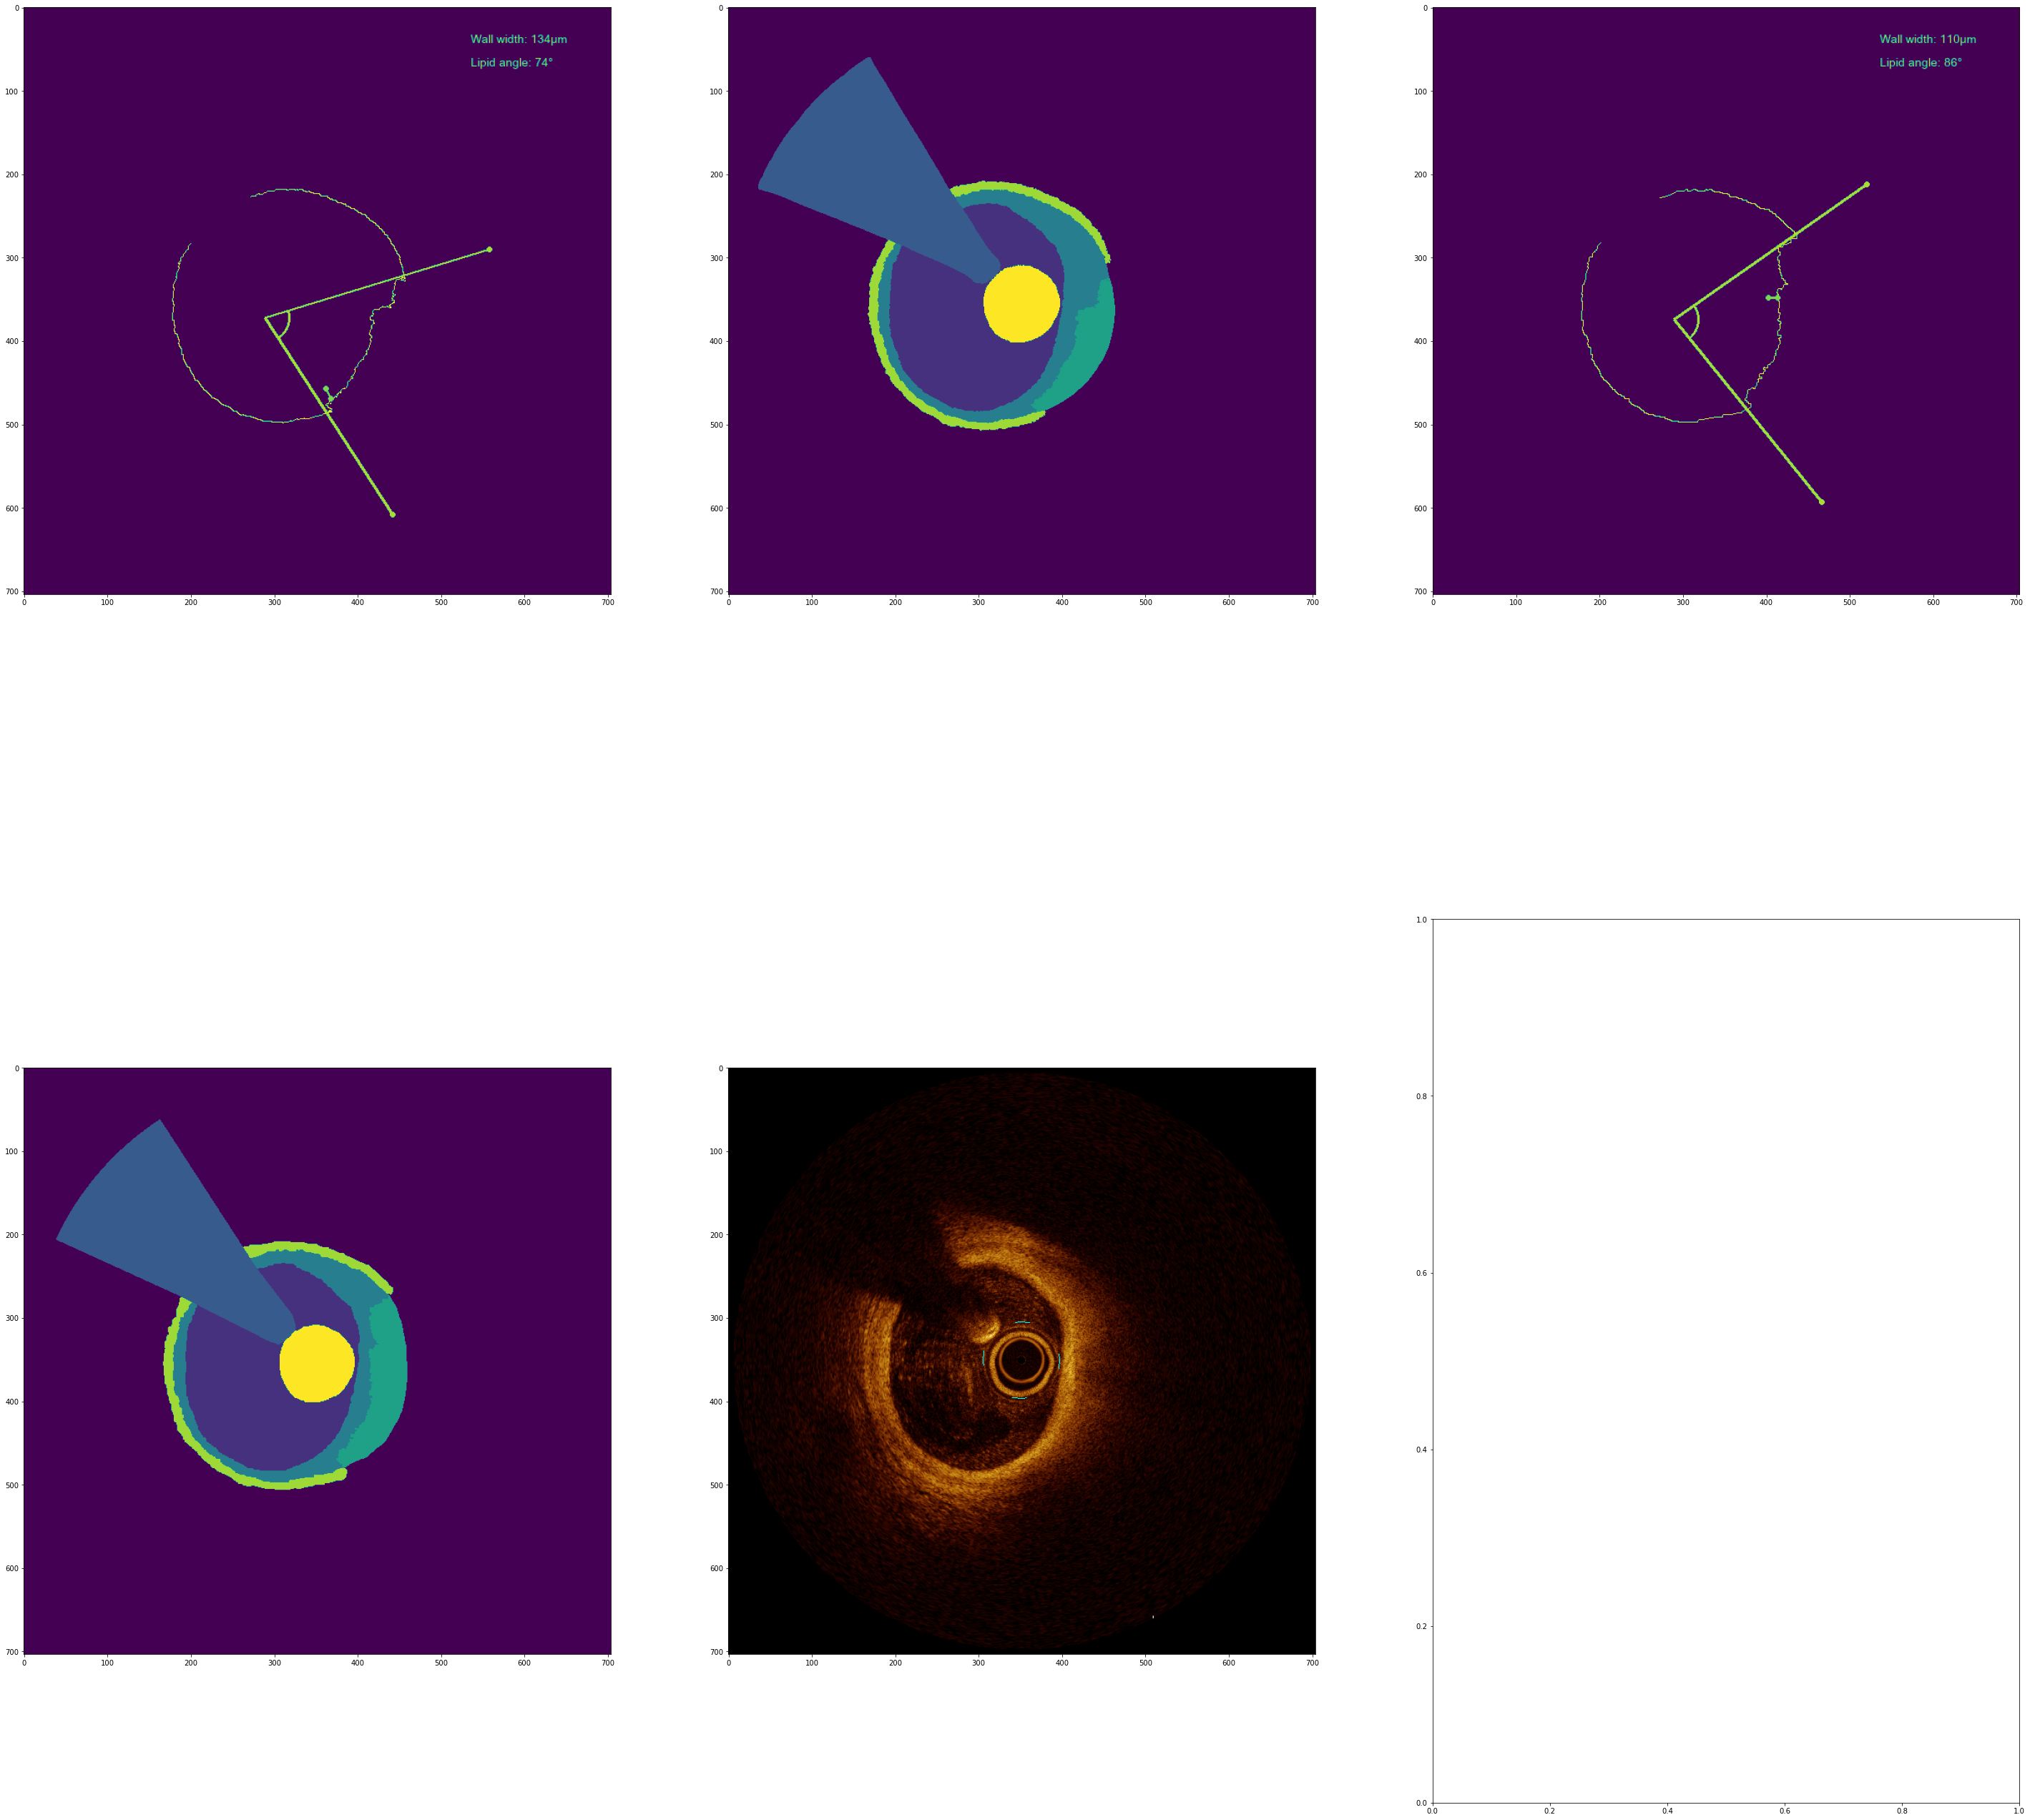

In [14]:
fig, axes = plt.subplots(2,3, figsize=(50,50))

axes = axes.flatten()

axes[0].imshow(image)
axes[1].imshow(img_pixel_data)
axes[2].imshow(image2)
axes[3].imshow(orig_pixel_data)
axes[4].imshow(merged_preproc.astype(np.int32))